## Find depth of upwelling from bottom average concentration on shelf

Look at concentrations near the bottom of the shelf and find the maximum value. This value can be tracked to the original depth it had at the beginning of the simulation.

In [37]:
import cmocean as cmo #cmap=cmo.cm.curl

import matplotlib.pyplot as plt

from math import *

%matplotlib inline

from netCDF4 import Dataset

import numpy as np

import seaborn as sns

import canyon_tools.readout_tools as rout

import canyon_tools.savitzky_golay as sg

In [38]:
def ConcArea(Tr, hfac, ra, bathy, sbdepth=-152.5):
    '''Tr:tracer field (nt,nz,ny,nx)
       hfac: fraction of open cell at center (nz,ny,nx)
       ra: array of cell horizontal areas (ny,nx)
       bathy : depths 2D array from the grid file (ny,nx)
       sbdepth: shelf break depth (negative value)
       
       RETURNS:
       ConcFiltered = concentration at cell closest to bottom(nt,ny,nx)
       Area of domain
       '''
    
    Conc = np.empty((19,360,360))
    ConcFiltered = np.empty((19,360,360))
    Area = np.empty((360,360))
    BottomInd = np.argmax(hfac[::-1,:,:]>0.0,axis=0) # start looking for first no-land cell from the bottom up.
    BottomInd = np.ones(np.shape(BottomInd))*89 - BottomInd # Get index of unreversed z axis
    
    print(np.shape(BottomInd))
    for tt in range(19):
        #print(tt)
        for j in range(360):
            for i in range(360):
                TrBottom = Tr[tt,BottomInd[i,j],i,j]
                Conc[tt,i,j] = TrBottom
                Area[i,j] = ra[i,j]
                
                    
            # Filter step noise
            ConcFiltered[tt,:,j] = sg.savitzky_golay(Conc[tt,:,j], 7,3) 
                
    maskShelf = mask2DCanyon(bathy, sbdepth)
    maskShelf = np.expand_dims(maskShelf,0) # expand along time dimension
    maskShelf = maskShelf + np.zeros(Conc.shape)
    
    return (np.ma.masked_array(ConcFiltered, mask=maskShelf),
            Area)

def mask2DCanyon(bathy, sbdepth=-152.5):
    '''Mask out the canyon from the shelf.
    bathy : depths 2D array from the grid file
    sbdepth: shelf depth, always negative float 
    Returns mask'''
    
    bathyMasked = np.ma.masked_less(-bathy, -152.5)
    return(bathyMasked.mask)



In [39]:
# Seaborn set up
sns.set()
sns.set_style('white')
sns.set_context('notebook')

In [40]:
CanyonGrid='/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run38/gridGlob.nc'
CanyonGridOut = Dataset(CanyonGrid)

CanyonGridNoC='/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run42/gridGlob.nc'
CanyonGridOutNoC = Dataset(CanyonGridNoC)

CanyonState='/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run38/stateGlob.nc'
CanyonStateOut = Dataset(CanyonState)

# Grid variables
nx = 360
ny = 360
nz = 90
nt = 19 # t dimension size 

xc = rout.getField(CanyonGrid, 'XC') # x coords tracer cells
yc = rout.getField(CanyonGrid, 'YC') # y coords tracer cells
rc = CanyonGridOut.variables['RC']
dxg = rout.getField(CanyonGrid, 'dxG') # x coords tracer cells
dyg = rout.getField(CanyonGrid, 'dyG') # y coords tracer cells

bathy = rout.getField(CanyonGrid, 'Depth')
hFacC = rout.getField(CanyonGrid, 'HFacC')
MaskC = rout.getMask(CanyonGrid, 'HFacC')

bathyNoC = rout.getField(CanyonGridNoC, 'Depth')
hFacCNoC = rout.getField(CanyonGridNoC, 'HFacC')
MaskCNoC = rout.getMask(CanyonGridNoC, 'HFacC')

rA = rout.getField(CanyonGrid, 'rA')

z = CanyonStateOut.variables['Z']

time = CanyonStateOut.variables['T']

### Define class and save attributes of each run

In [41]:
import sys
sys.path.append('../PythonScripts/Paper1Figures')

import canyon_records 
import nocanyon_records

records = canyon_records.main()
recordsNoC = nocanyon_records.main()

### Define constants and scales

In [42]:
# Constants and scales

L = 6400.0 # canyon length
R = 5000.0 # Upstream radius of curvature
g = 9.81 # accel. gravity
Wsb = 13000 # Width at shelf break
Hs = 150.0 # Shelf break depth
Hh = 132.5 # depth of canyon head
s=0.005
W = 8300
# NOTE: The default values of all functions correspond to the base case

def Dh(f=9.66E-4,L=6400.0,N=5.5E-3):
    '''Vertical scale Dh'''
    return(f*L/(N))
    
def Z_AH2010(U=0.36,L=6400.0,N=5.5E-3,R=5000.0,f=9.66E-4):
    '''Depth of upwelling as scaled in Allen and Hickey 2010, before estimation of F'''
    return(1.3*Dh(f,L,N)*((F(Ro(U,f,R))*Ro(U,f,L))**(0.5))+0.06*Dh(f,L,N))

def Z_HA2013(U=0.36,L=6400.0,N=5.5E-3,R=5000.0,f=9.66E-4,W=8300,s=0.005):
    '''Depth of upwelling as scaled in Howatt and Allen 2013'''
    Se = (s*N)/(f*((F(Ro(U,f,W))/Ro(U,f,L))**(1/2)))
    return(1.8*(((F(Ro(U,f,W))*Ro(U,f,L))**(1/2))*(1-0.42*Se))+0.05)
   
def Ro(U=0.36,f=9.66E-4,R=5000.0):
    '''Rossby number using radius of curvature as length scale'''
    return(U/(f*R))

def F(Ro):
    '''Function that estimates the hability of the flow to follow isobaths'''
    return(Ro/(0.9+Ro))

def Rw(U=0.36,f=9.66E-5,Wsb=13000.0): 
    '''Rossby number using width at shelf break as length scale'''
    return(U/(f*Wsb))

def Bu(N=5.5E-3,f=9.66E-5,L=6400.0,Hs=150.0):
    '''Burger number'''
    return(N*Hs/(f*L))

def RossbyRad(N=5.5E-3,Hs=150.0,f=9.66E-4):
    '''1st Rossby radius of deformation'''
    return(N*Hs/f)

def Phi(U=0.37,Wsb=13000.0,f=9.66E-5,L=6400,N=5.5E-3,R=5000.0):
    '''Flux of upwelling as in Allen and Hickey 2010 , with expected coef of 1/4'''
    return(U*Wsb*Dh(f,L,N)*(F(Ro(U,f,R))**(3/2))*(Ro(U,f,L)**(0.5)))

In [7]:
# Save max. tracer concentration per 1/2 day into class record.

for record in records:
    
    filename=('/ocean/kramosmu/MITgcm/TracerExperiments/%s/%s/ptracersGlob.nc' %(record.exp_code,record.run_num))
    Tr = rout.getField(filename,'Tr2') 
    ConcFiltSq, AreaSq = ConcArea(Tr, hFacC, rA, bathy)
    record.max_conc = np.max(np.max(ConcFiltSq,1),1)
    

(360, 360)


/home/kramosmu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:24: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(360, 360)
(360, 360)
(360, 360)
(360, 360)
(360, 360)
(360, 360)
(360, 360)
(360, 360)
(360, 360)
(360, 360)
(360, 360)
(360, 360)
(360, 360)
(360, 360)
(360, 360)
(360, 360)
(360, 360)
(360, 360)
(360, 360)


In [44]:
for record in records:
    
    filename=('/ocean/kramosmu/MITgcm/TracerExperiments/%s/%s/ptracersGlob.nc' %(record.exp_code,record.run_num))
    Tr = rout.getField(filename,'Tr2') 
    ConcFiltSq, AreaSq = ConcArea(Tr, hFacCNoC, rA, bathyNoC)
    record.max_conc_adv = np.max(np.max(ConcFiltSq,1),1)
 

(360, 360)


/home/kramosmu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:24: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(360, 360)
(360, 360)
(360, 360)
(360, 360)
(360, 360)
(360, 360)
(360, 360)
(360, 360)
(360, 360)
(360, 360)
(360, 360)
(360, 360)
(360, 360)
(360, 360)
(360, 360)
(360, 360)
(360, 360)
(360, 360)
(360, 360)


In [45]:
for rec in records:
    print(rec.name)

CNTDIFF_run38
CNTDIFF_run37
CNTDIFF_run36
CNTDIFF_run45
CNTDIFF_run73
CNTDIFF_run75
CNTDIFF_run67
CNTDIFF_run51
CNTDIFF_run69
CNTDIFF_run71
3DVISC_run01
3DVISC_run02
3DVISC_run03
3DVISC_run04
3DVISC_run05
3DVISC_run06
LOWEST_BF_run01
LOWEST_BF_run03
LOWEST_BF_run07
LOWEST_BF_run11


### Maximum concentration on shelf bottom

AttributeError: 'run' object has no attribute 'max_conc'

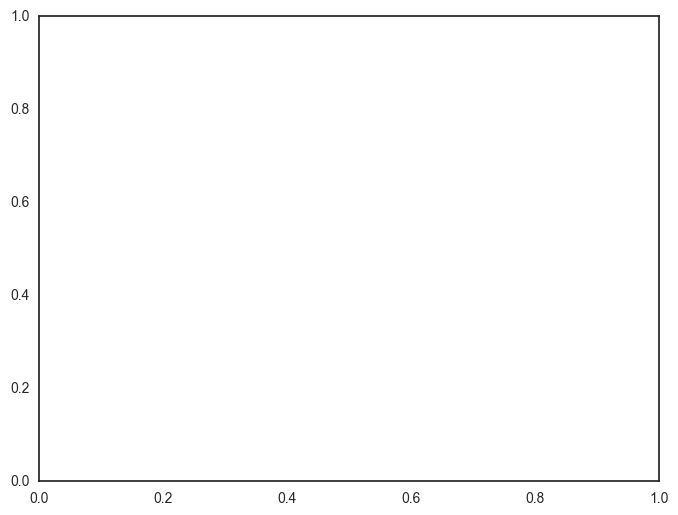

In [46]:
# Choose only the runs that satisfy all restrictions in Allen and Hickey (2010)

fig,ax = plt.subplots(1,1,figsize=(8,6))
labels=[]

for rec in records:
    
    plt1 = ax.plot(time[:]/(3600*24),rec.max_conc,
                   marker = rec.mstyle,
                   markersize = rec.msize,
                   color = sns.xkcd_rgb[rec.color],
                   label=rec.label)
    ax.legend(bbox_to_anchor=(1.7,1))

 
 
ax.set_title('Maximum bottom concentration Tr1')
ax.set_ylabel('Tr Concentration (Mol/l)')
ax.set_xlabel('Days')


plt.show()



### Find depth of upwelling from maximum concentration on shelf bottom

 Since tr profile is linear, we can use the fact that at 2.5 m TrConc is 2 Mol/l and at 1190 m it is 45 Mol/l to
 go from tracer concentration to depth use:
 
 $Z = \frac{1190.0-2.5}{45.0-2.0}(TrConc-2.0)+2.5$


In [47]:
#Check 

TrConc = 3.25
TrDepth = ((1190.0-2.5)/(45.0-2.0))*(TrConc-2.0)+2.5
print('Initial depth of TrConc %f Mol/l is %f m' %(TrConc,TrDepth))


Initial depth of TrConc 3.250000 Mol/l is 37.020349 m


In [48]:
def conc_to_depth(conc,z1=2.5,z2=1190.0,conc1=2.0,conc2=45.0):
    ''' conc: float, the concentration of which to calculate the initial depth
        z1=2.5 m
        z2=1190.0 m
        conc1=2.0 [C]
        conc2=45.0 [C] (default values for tracer profile in base case).
        return: float. Initial depth at which to find concentration conc. 
        Note that depth of upwelling is this depth minus the depth of the canyon head.'''
    
    return(((z2-z1)/(conc2-conc1))*(conc-conc1)+z1)
   

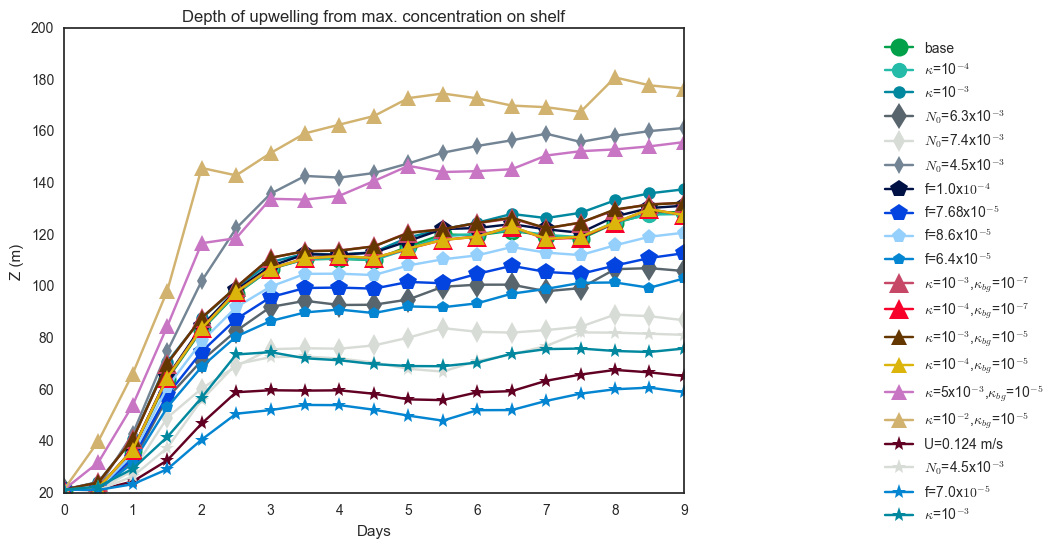

In [27]:
fig,ax = plt.subplots(1,1,figsize=(8,6))
labels=[]


for rec in records:
    
    plt1 = ax.plot(time[:]/(3600*24),conc_to_depth(rec.max_conc)-Hh,
                   marker = rec.mstyle,
                   markersize = rec.msize,
                   color = sns.xkcd_rgb[rec.color],
                   label=rec.label)
   
    ax.set_title('Depth of upwelling from max. concentration on shelf')
    ax.set_ylabel('Z (m)')
    ax.set_xlabel('Days')

    ax.legend(bbox_to_anchor=(1.6,1))

plt.show()


NameError: name 'CNTDIFF_base' is not defined

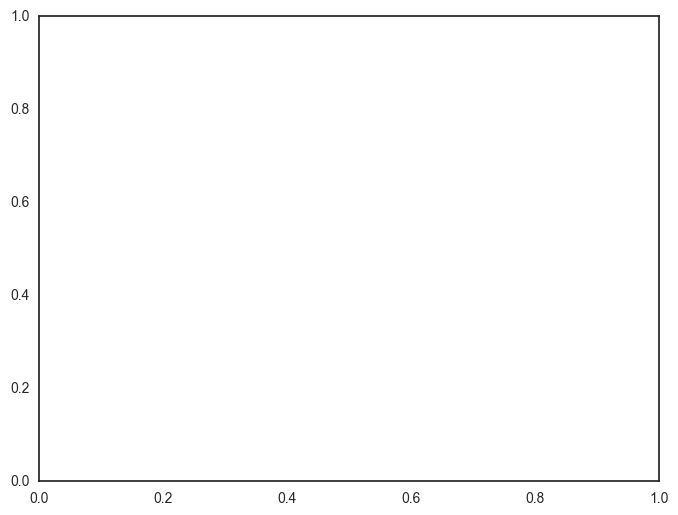

In [28]:
fig,ax = plt.subplots(1,1,figsize=(8,6))
labels=[]


for rec in records:
    
    plt1 = ax.plot(time[:]/(3600*24),(conc_to_depth(rec.max_conc)-Hh)/(conc_to_depth(CNTDIFF_base.max_conc)-Hh),
                   marker = rec.mstyle,
                   markersize = rec.msize,
                   color = sns.xkcd_rgb[rec.color],
                   label=rec.label)
   
    ax.set_title('Relative depth of upwelling from max. concentration on shelf')
    ax.set_ylabel('$Z/Z_{base}$')
    ax.set_xlabel('Days')

    ax.legend(bbox_to_anchor=(1.6,1))

plt.show()


In [14]:
records_Kv = [CNTDIFF_kv7,
              CNTDIFF_base, 
              CNTDIFF_kv4, 
              CNTDIFF_kv3,
              DIFF3D_run04,
              ]

fig,ax = plt.subplots(1,1,figsize=(8,6))
labels=[]


for rec in records_Kv:
    
    plt1 = ax.plot(time[:]/(3600*24),conc_to_depth(rec.max_conc)-Hh,
                   linestyle='-',
                   linewidth = 3,
                   color = sns.xkcd_rgb[rec.color],
                   label=rec.label)
   
    plt2 = ax.plot(time[:]/(3600*24),conc_to_depth(rec.max_conc_adv)-Hh,
                   linestyle='--',
                   linewidth = 3,
                   color = sns.xkcd_rgb[rec.color],
                   label='Adv_Tr %s ' %rec.label)
   
    ax.set_title('Depth of upwelling from max. concentration on shelf ')
    ax.set_ylabel('Z (m)')
    ax.set_xlabel('Days')

    ax.legend(bbox_to_anchor=(1.6,1))

    
   
plt.show()


NameError: name 'CNTDIFF_kv7' is not defined

In [ ]:
records_Kv = [CNTDIFF_kv7,
             CNTDIFF_base, 
             CNTDIFF_kv4, 
             CNTDIFF_kv3,
             DIFF3D_run04,
             DIFF3D_run05,
             DIFF3D_run06,
             DIFF3D_run07]

fig,ax = plt.subplots(1,1,figsize=(8,6))
labels=[]


for rec in records_Kv:
    
    plt1 = ax.plot(time[:]/(3600*24),(conc_to_depth(rec.max_conc)-Hh)-(conc_to_depth(CNTDIFF_base.max_conc)-Hh),
                   marker = rec.mstyle,
                   markersize = rec.msize,
                   color = sns.xkcd_rgb[rec.color],
                   label=rec.label)
   
    ax.set_title('Relative depth of upwelling from max. concentration on shelf ')
    ax.set_ylabel('Z (m)')
    ax.set_xlabel('Days')

    ax.legend(bbox_to_anchor=(1.6,1))


plt.show()

### Compare measured depth of upwelling to AH2010 and HA2013 estimates

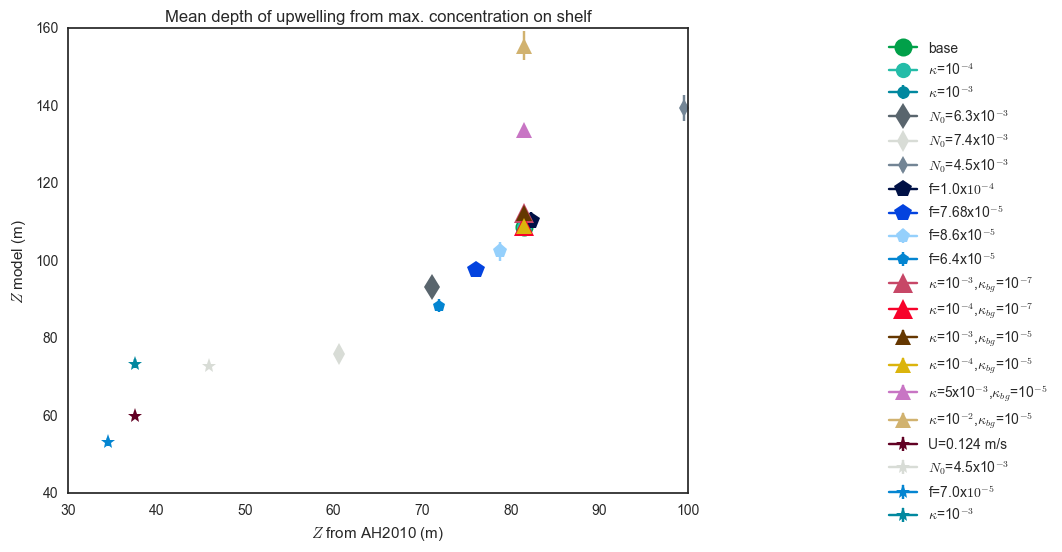

In [30]:
fig,ax = plt.subplots(1,1,figsize=(8,6))
labels=[]


for rec in records:
    
    plt1 = ax.errorbar(Z_AH2010(rec.u,L,rec.N,R,rec.f),np.mean(conc_to_depth(rec.max_conc)[6:8]-Hh),
                       np.std(conc_to_depth(rec.max_conc)[6:8]-Hh),
                       marker = rec.mstyle,
                       markersize = rec.msize,
                       color = sns.xkcd_rgb[rec.color],
                       label=rec.label)
   
  
    ax.set_title('Mean depth of upwelling from max. concentration on shelf')
    ax.set_ylabel('$Z$ model (m)')
    ax.set_xlabel('$Z$ from AH2010 (m)')

    ax.legend(bbox_to_anchor=(1.6,1))

#plt2 = ax.plot(range(40,100),range(40,100),'-k')
    
plt.show()


CNTDIFF_run38 80.2740821136 96.473327986 112.407272727
CNTDIFF_run37 80.2740821136 95.9454956548 112.407272727
CNTDIFF_run36 80.2740821136 93.5091302878 112.407272727
CNTDIFF_run45 68.3016658893 76.9175214995 98.1333333333
CNTDIFF_run73 56.0663418764 56.9063211702 83.5459459459
CNTDIFF_run75 101.225810506 128.578306384 137.386666667
CNTDIFF_run67 81.4522757333 98.3323883416 116.363636364
CNTDIFF_run51 71.947416985 79.5177515203 89.3672727273
CNTDIFF_run69 76.1725087703 89.2191688523 100.072727273
CNTDIFF_run71 64.5858788273 65.649750638 74.4727272727
3DVISC_run01 80.2740821136 94.6760672509 112.407272727
3DVISC_run02 80.2740821136 94.3579791432 112.407272727
3DVISC_run03 80.2740821136 94.6761619385 112.407272727
3DVISC_run04 80.2740821136 94.3802821385 112.407272727
3DVISC_run05 80.2740821136 104.868630816 112.407272727
3DVISC_run06 80.2740821136 120.531382273 112.407272727
LOWEST_BF_run01 35.4679960021 30.8722761752 112.407272727
LOWEST_BF_run03 44.428033761 45.7885451168 137.38666666

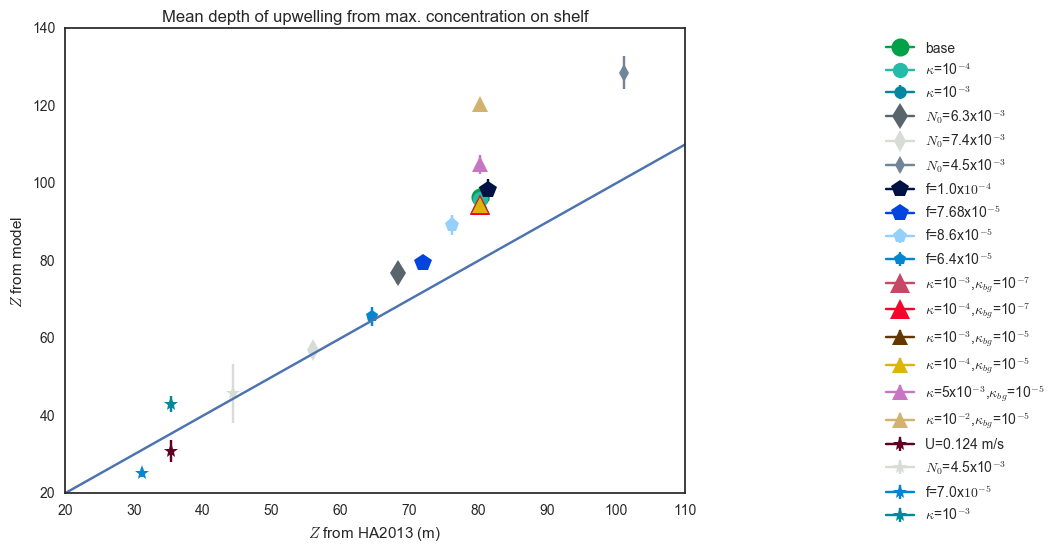

In [53]:
fig,ax = plt.subplots(1,1,figsize=(8,6))
labels=[]


for rec in records:
    
    plt1 = ax.errorbar(Z_HA2013(rec.u,L,rec.N,R,rec.f,W,s)*(Dh(rec.f,L,rec.N)),
                       np.mean(conc_to_depth(rec.max_conc_adv)[6:8]-Hh),
                       np.std(conc_to_depth(rec.max_conc_adv)[6:8]-Hh),
                       marker = rec.mstyle,
                       markersize = rec.msize,
                       color = sns.xkcd_rgb[rec.color],
                       label=rec.label)
   
    print(rec.name, Z_HA2013(rec.u,L,rec.N,R,rec.f,W,s)*(Dh(rec.f,L,rec.N)),
          np.mean(conc_to_depth(rec.max_conc_adv)[6:8]-Hh),Dh(rec.f,L,rec.N))
    ax.set_title('Mean depth of upwelling from max. concentration on shelf')
    ax.set_ylabel('$Z$ from model ')
    ax.set_xlabel('$Z$ from HA2013 (m)')

    ax.legend(bbox_to_anchor=(1.6,1))

#plt2 = ax.plot(range(40,100),range(40,100),'-k')
ax.plot(np.linspace(20,110,50),np.linspace(20,110,50))    
plt.show()


Mean depth of upwelling (mean taken during the advective phase), errorbars correspond to std deviation. The black line is the 1:1 plot of Z. The measured depth of upwelling is about 30 m deeper than the estimated one. This may be because when I look for the bottom concentrations on shelf, the shelf "definition" goes too deep around the rim of the canyon. 

### Depth of upwelling for no canyon cases

In [17]:
# Save max. tracer concentration per 1/2 day into class record.

for recordNoC in recordsNoC:
    
    filenameNoC=('/ocean/kramosmu/MITgcm/TracerExperiments/%s/%s/ptracersGlob.nc' %(recordNoC.exp_code,recordNoC.run_num))
    TrNoC = rout.getField(filenameNoC,'Tr1') 
    
    ConcFiltSq, AreaSq = ConcArea(TrNoC, hFacCNoC, rA, bathyNoC)
    recordNoC.max_conc = np.max(np.max(ConcFiltSq,1),1)
    

(360, 360)


/home/kramosmu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:24: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(360, 360)
(360, 360)


KeyboardInterrupt: 

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(8,6))
labels=[]

records_AH2010_NoC = [CNTDIFF_kv7NoC,
                      CNTDIFF_baseNoC, 
                      CNTDIFF_kv4NoC, 
                      CNTDIFF_kv3NoC,
                      CNTDIFF_N63NoC, 
                      CNTDIFF_N74NoC,
                      CNTDIFF_N45NoC,
                      CNTDIFF_f100NoC,
                      CNTDIFF_f76NoC,
                      CNTDIFF_f86NoC,
                      DIFF3D_run04NoC,
                      DIFF3D_run05NoC,
                      DIFF3D_run06NoC,
                      DIFF3D_run07NoC,
                      LESS_BF_u31NoC,
                      LESS_BF_u20NoC]

for rec in records_AH2010_NoC:
    
    plt1 = ax.errorbar(Z(rec.u,L,rec.N,R,rec.f),np.mean(conc_to_depth(rec.max_conc)[8:]-Hh),
                       np.std(conc_to_depth(rec.max_conc)[8:]-Hh),
                       marker = rec.mstyle,
                       markersize = rec.msize,
                       color = sns.xkcd_rgb[rec.color],
                       label=rec.label)
    
    ax.set_title('NO CANYON CASES - Mean depth of upwelling from max. concentration on shelf')
    ax.set_xlabel('Z from AH2010 (m) ')
    ax.set_ylabel('Z from BAC (m)')

    ax.legend(bbox_to_anchor=(1.6,1))

plt2 = ax.plot(range(40,100),range(40,100),'-k')
    
plt.show()


In [ ]:
fig,ax = plt.subplots(1,1,figsize=(8,6))
labels=[]

for rec,recNoC in zip(records_AH2010,records_AH2010_NoC):
    
    plt1 = ax.plot(np.mean(conc_to_depth(recNoC.max_conc)[8:]-Hh),np.mean(conc_to_depth(rec.max_conc)[8:]-Hh),
                       marker = rec.mstyle,
                       markersize = rec.msize,
                       color = sns.xkcd_rgb[rec.color],
                       label=rec.label)
    
    ax.set_title('Comparison mean depth of upwelling canyon and no canyon cases')
    ax.set_xlabel('Z no canyon (m) ')
    ax.set_ylabel('Z canyon  (m)')

    ax.legend(bbox_to_anchor=(1.6,1))

plt2 = ax.plot(range(30,70),range(30,70),'-k')
    
plt.show()


The depth of upwelling in the canyon base case increases by about 70 m with respect to the no canyon base case when measured using BAC.